In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import tensorflow

2025-04-18 14:45:31.708799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744987531.943275      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744987532.007324      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import cv2

def generate_mask_from_txt(txt_path, image_size):
    mask = np.zeros(image_size, dtype=np.uint8)

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 8:
                continue
            coords = list(map(float, parts[:-2]))
            points = np.array(coords, dtype=np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [points], 255)

    return mask

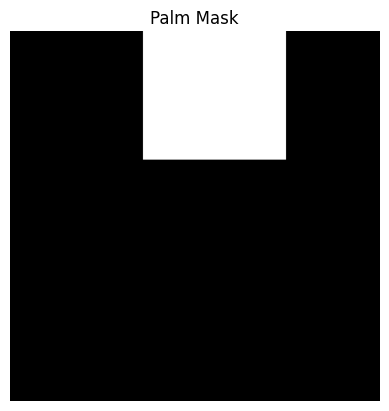

In [3]:
mask = generate_mask_from_txt(
    '/kaggle/input/palm-segmentationn/train/labelTxt/Hand_0000040_jpg.rf.c843516bea251df7a006a7f39bdc93f8.txt',
    image_size=(256, 256)  
)

import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray')
plt.title("Palm Mask")
plt.axis('off')
plt.show()

In [4]:
import tensorflow as tf
import os

def load_image_and_mask(image_path, label_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]
    mask = generate_mask_from_txt(label_path, (h, w))

    image = cv2.resize(image, target_size)
    mask = cv2.resize(mask, target_size)

    image = image / 255.0
    mask = (mask > 0).astype(np.float32)

    return image, mask[..., np.newaxis]  

In [14]:
def create_dataset(image_dir, label_dir, batch_size=8, target_size=(128, 128)):
    image_files = sorted(os.listdir(image_dir))

    def generator():
        for fname in image_files:
            image_path = os.path.join(image_dir, fname)
            label_name = fname.replace('.jpg', '.txt')
            label_path = os.path.join(label_dir, label_name)
            if not os.path.exists(label_path):
                continue
            image, mask = load_image_and_mask(image_path, label_path, target_size)
            yield image, mask

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(target_size[0], target_size[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(target_size[0], target_size[1], 1), dtype=tf.float32),
        )
    )
    
    return dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    # Bridge
    b = conv_block(p3, 512)

    # Decoder
    d3 = decoder_block(b, s3, 256)
    d2 = decoder_block(d3, s2, 128)
    d1 = decoder_block(d2, s1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)

    return models.Model(inputs, outputs)

In [16]:
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_dataset = create_dataset(
    '/kaggle/input/palm-segmentationn/train/images',
    '/kaggle/input/palm-segmentationn/train/labelTxt'
)

val_dataset = create_dataset(
    '/kaggle/input/palm-segmentationn/valid/images',
    '/kaggle/input/palm-segmentationn/valid/labelTxt'
)

model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.8201 - loss: 0.4221 - val_accuracy: 0.9318 - val_loss: 0.1598
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9195 - loss: 0.2785 - val_accuracy: 0.9286 - val_loss: 0.1395
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9406 - loss: 0.1378 - val_accuracy: 0.9588 - val_loss: 0.0922
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9489 - loss: 0.1198 - val_accuracy: 0.9643 - val_loss: 0.0853
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9499 - loss: 0.1184 - val_accuracy: 0.9143 - val_loss: 0.1609
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8869 - loss: 0.2896 - val_accuracy: 0.9120 - val_loss: 0.2020
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8860 - loss: 0.2928 - val_accuracy: 0.9364 - val_loss: 0.1931
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9157 - loss: 0.2443 - val_accuracy: 0

In [17]:
test_dataset = create_dataset(
    '/kaggle/input/palm-segmentationn/test/images',
    '/kaggle/input/palm-segmentationn/test/labelTxt'
)

model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9808 - loss: 0.0465


[0.043981555849313736, 0.981689453125]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


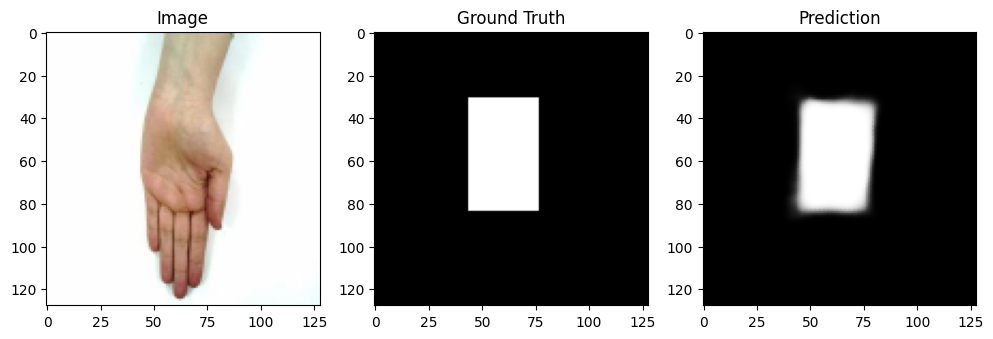

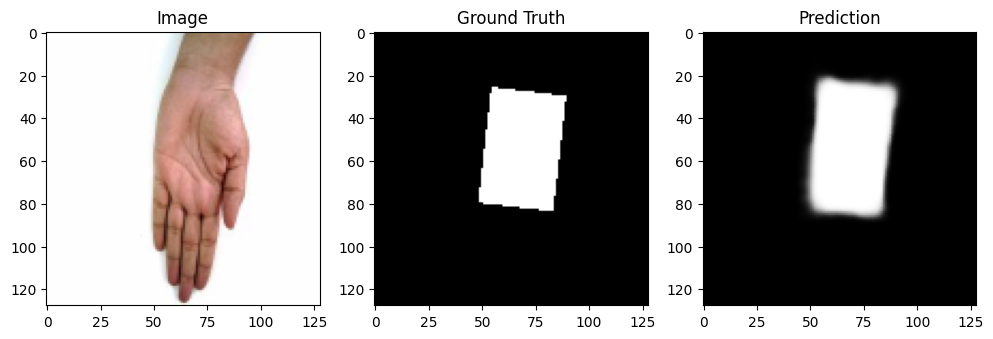

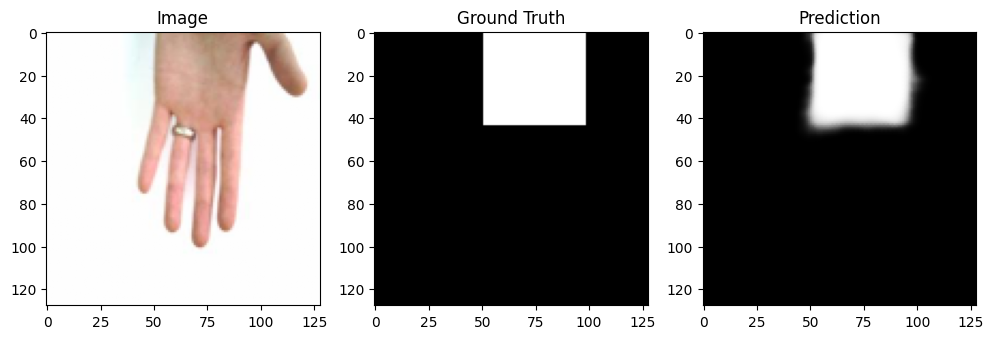

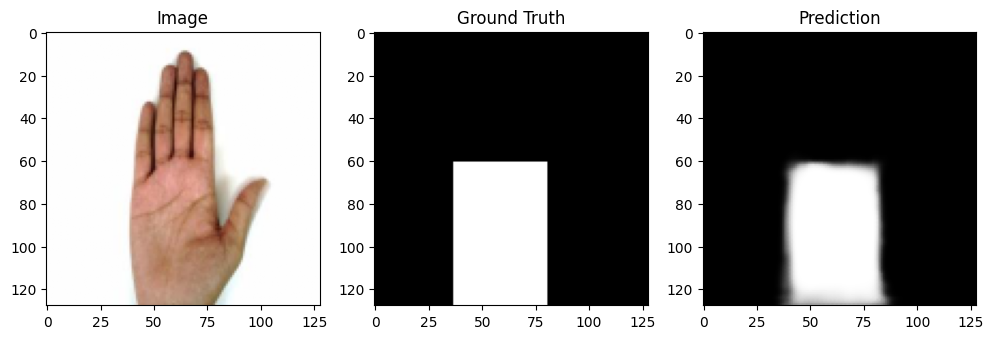

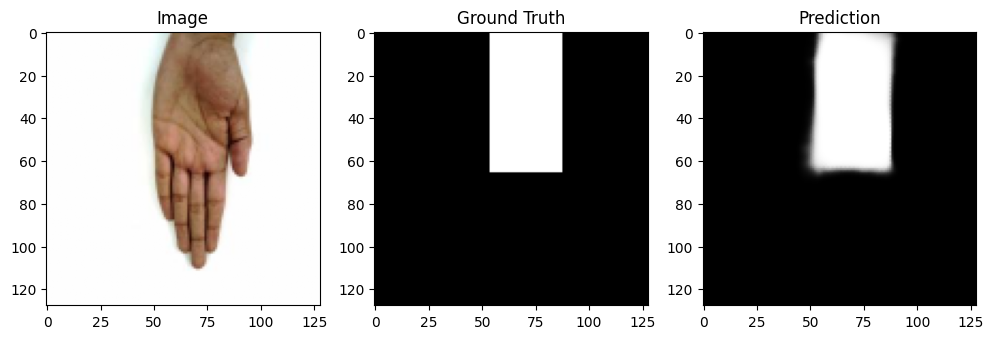

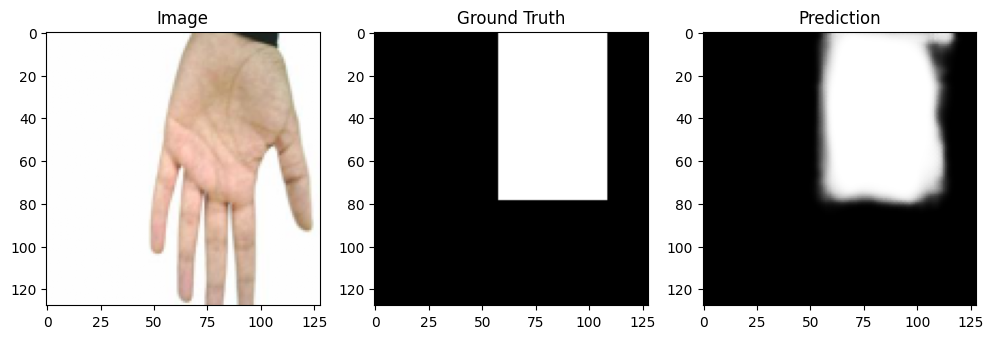

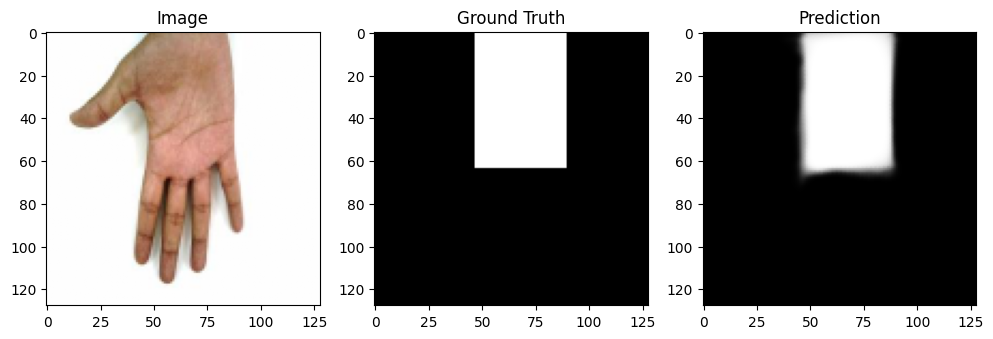

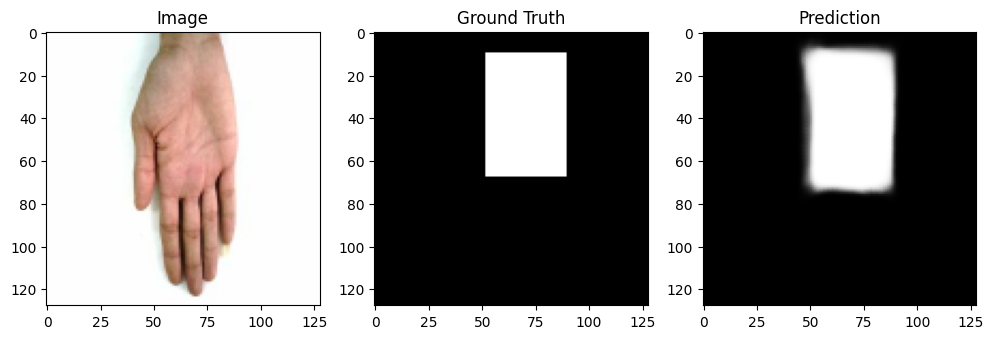

In [18]:
for image, mask in test_dataset.take(1):
    pred_mask = model.predict(image)

    for i in range(len(image)):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image[i])
        plt.title("Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask[i].numpy().squeeze(), cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[i].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.show()

In [19]:
model.save("palm_segmentation_model.h5") 